#### In vector quantized Variational Autoencoder we project the continuous latent representation of encoder to descrete latent representations using something called learned codebook. These descrete latents are then passed onto the decoder for reconstruction. After the encoder generates its latent we compute the distance between this continuous vector latent and the descrete latent in the codebook and pick the closest codes. The small problem arises during backward pass because to choose the closest descrete code , we use argmin whose gradient is not possible , and because of this the gradients cannot flow backwards. A workaround to this Straight-Through Estimator where we implement the forward pass in such way that during the backward pass the gradints flow in a different route. i.e. with e_j = z + (e_j -z).detach() , where e_j are our codes and z is the representation from encoder.

In [ ]:
!pip install torchview

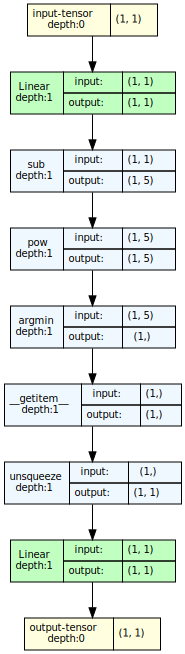

In [ ]:
import torch
import torch.nn as nn
from torchview import draw_graph

class quantized (nn.Module):

  def __init__(self):
    super().__init__()

    self.enc = nn.Linear(1,1)
    self.codebook = nn.Parameter(torch.tensor([-10.0,0.0,3.0,6,0]))
    self.dec = nn.Linear(1,1)


  def forward(self,x):
    z = self.enc(x)
    closest = torch.argmin((z - self.codebook)**2,dim= -1)
    e_j = self.codebook[closest].unsqueeze(0)
    x_hat = self.dec(e_j)
    return x_hat

model = quantized()
out = model(torch.tensor([1.0]))

out.backward()

# visualizing the computational flow
model_graph = draw_graph(model, input_size=(1,1))
model_graph.visual_graph


#print(model.enc.weight.grad,model.dec.weight.grad)

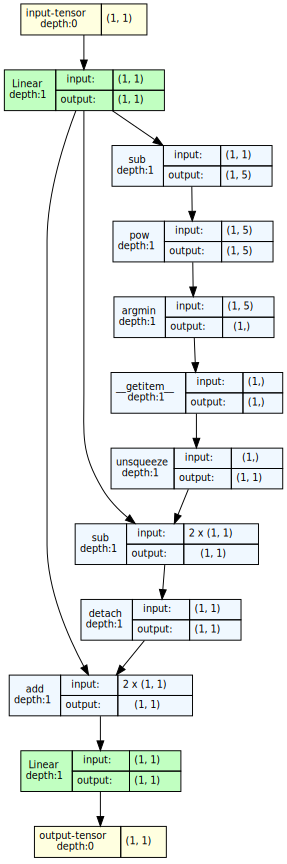

In [ ]:
import torch
import torch.nn as nn
from torchview import draw_graph

class quantized (nn.Module):

  def __init__(self):
    super().__init__()

    self.enc = nn.Linear(1,1)
    self.codebook = nn.Parameter(torch.tensor([-10.0,0.0,3.0,6,0]))
    self.dec = nn.Linear(1,1)


  def forward(self,x):
    z = self.enc(x)
    closest = torch.argmin((z - self.codebook)**2,dim= -1)
    e_j = self.codebook[closest].unsqueeze(0)
    e_j = z + (e_j - z).detach() # to flow the gradients
    x_hat = self.dec(e_j)
    return x_hat

model = quantized()
out = model(torch.tensor([1.0]))

out.backward()

# visualizing the computational flow
model_graph = draw_graph(model, input_size=(1,1))
model_graph.visual_graph


#print(model.enc.weight.grad,model.dec.weight.grad)

In [1]:
# implementing vector quantizer
import torch.nn as nn
import torch
class VectorQuantizer(nn.Module):

  def __init__(self,codebook_size, embeddding_dim):
    super().__init__()

    self.embedding = nn.Embedding(codebook_size, embeddding_dim)
    self.embedding.weight.data.uniform_(-1/codebook_size, 1/codebook_size)

    self.codebook_size = codebook_size
    self.embedding_dim = embeddding_dim

  def forward(self,x, efficient=True):

    if not efficient:
      # x -> (B,L)
      # emb -> (C, L)
      # we want each sample in the batch to undergo operation with entire embedding matrix.
      # so we reshape the x and q as . x -> (B,1,L) and q-> (B,C,L)
      z = x.unsqueeze(1)
      batch_size = x.shape[0]
      emb = self.embedding.weight.unsqueeze(0).repeat(batch_size,1,1)
      distance = torch.sum((z - emb)**2,dim=-1)
      return distance

    else:

      # we need to do (x-emb)**2  , which is x**2 - 2*x*emb + emb**2

      x2 = torch.sum(x**2, dim = -1,keepdim=True)
      emb2 = torch.sum(self.embedding.weight **2 ,dim = -1).unsqueeze(0)
      xemb = torch.matmul(x,self.embedding.weight.transpose(-2,-1))
      distance = x2 - 2*xemb + emb2

    closest = torch.argmin(distance, dim=-1)

    # we can now take the closest latents (quantized latents) directly with embedding matrix by passing in the indices

    qunatized_latents = self.embedding(closest)
    return qunatized_latents


vq = VectorQuantizer(6,2)
x = torch.randn((4,2))
out = vq(x)
print(out.shape)

torch.Size([4, 2])


In [32]:
# simple linear vqvae
import torch.nn as nn

class LinearVectorQuantizedVAE(nn.Module):

  def __init__(self,latent_dim=2,codebook_size = 512):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Linear(28*28, 128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,latent_dim),
    )

    self.decoder = nn.Sequential(
        nn.Linear(latent_dim,64),
        nn.ReLU(),
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,28*28),
        nn.Sigmoid()
    )

    self.vq = VectorQuantizer(codebook_size,latent_dim)

  def forward_enc(self,x):
    z = self.encoder(x)
    return z

  def forward_vq(self,z):
    codes = self.vq(z)

    # codebook and commitment loss #
    codebook_loss = torch.mean((codes - z.detach())**2)
    commitment_loss = torch.mean((codes.detach() - z)**2)

    codes = z + (codes-z).detach()
    return z,codes,codebook_loss,commitment_loss


  def forward_dec(self,codes):
    x_hat = self.decoder(codes)
    return x_hat


  def forward (self,x):
    x = x.flatten(1)
    z = self.forward_enc(x)
    z,codes,codebook_loss,commitment_loss = self.forward_vq(z)
    x_hat = self.forward_dec(codes)
    x_hat = x_hat.reshape(-1,1,28,28)
    return z,x_hat,codes,codebook_loss,commitment_loss


linearvqvae = LinearVectorQuantizedVAE()
x = torch.randn((4,1,28,28))
encoded,decoded,codes,codebook_loss,commitment_loss = linearvqvae(x)

In [2]:
from tqdm import tqdm
import numpy as np

def train(model,
          trainloader,
          testloader,
          batch_size,
          training_iterations,
          evaluation_iterations,
          model_type="VQVAE"):


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    optimizer =torch.optim.Adam(model.parameters(), lr=0.0005)

    train_loss = []
    evaluation_loss = []

    encoded_data_per_eval = []
    quantized_encoded_data_per_eval = [] if model_type == "VQVAE" else None
    train_losses = []
    evaluation_losses = []

    pbar = tqdm(range(training_iterations))

    train = True

    step_counter = 0
    while train:

        for images, labels in trainloader:

            images = images.to(device)

            if model_type == "VQVAE":
                encoded,decoded, quantized_encoded, codebook_loss, commitment_loss = model(images)
                reconstruction_loss = torch.mean((images-decoded)**2)
                loss = reconstruction_loss + codebook_loss +  0.25*commitment_loss

            train_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if step_counter % evaluation_iterations == 0:

                model.eval()

                encoded_evaluations = []
                if model_type == "VQVAE":
                    quantized_encoded_evaluations = []

                for images, labels in testloader:

                    images = images.to(device)

                    if model_type == "VQVAE":
                        encoded, decoded, quantized_encoded, codebook_loss, commitment_loss = model(images)
                        reconstruction_loss = torch.mean((images-decoded)**2)
                        loss = reconstruction_loss + codebook_loss +  0.25*commitment_loss

                    evaluation_loss.append(loss.item())

                    encoded, labels = encoded.cpu(), labels.reshape(-1,1)

                    encoded_evaluations.append(torch.cat((encoded.flatten(1), labels), axis=-1))

                    if model_type == "VQVAE":
                        quantized_encoded = quantized_encoded.cpu()
                        quantized_encoded_evaluations.append(torch.cat((quantized_encoded.flatten(1), labels), axis=-1))


                encoded_data_per_eval.append(torch.concatenate(encoded_evaluations).detach())
                if model_type == "VQVAE":
                    quantized_encoded_data_per_eval.append(torch.concatenate(quantized_encoded_evaluations).detach())


                train_loss = np.mean(train_loss)
                evaluation_loss = np.mean(evaluation_loss)

                train_losses.append(train_loss)
                evaluation_losses.append(evaluation_loss)

                train_loss = []
                evaluation_loss = []

                model.train()

            step_counter += 1
            pbar.update(1)


            if step_counter >= training_iterations:
                print("Completed Training!")
                train = False
                break

    encoded_data_per_eval = [np.array(i) for i in encoded_data_per_eval]

    if model_type == "VQVAE":
        quantized_encoded_data_per_eval = [np.array(i) for i in quantized_encoded_data_per_eval]

    print("Final Training Loss", train_losses[-1])
    print("Final Evaluation Loss", evaluation_losses[-1])

    return model, train_losses, evaluation_losses, encoded_data_per_eval, quantized_encoded_data_per_eval

In [3]:
import torchvision
import torchvision.transforms as transforms

train_set  = torchvision.datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

test_set  = torchvision.datasets.MNIST(
    root = './data',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(train_set,batch_size=128,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=128,shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.55MB/s]


In [33]:
(linear_vqvae, train_losses,
 evaluation_losses, linear_vqvae_encoded_data_per_eval,
 linear_vqvae_quantized_encoded_data_per_eval) = train(linearvqvae,
                                                       train_loader,
                                                       test_loader,
                                                       batch_size=64,
                                                       training_iterations=2500,
                                                       evaluation_iterations=250,
                                                       model_type="VQVAE")

100%|██████████| 2500/2500 [00:48<00:00, 51.85it/s]

Completed Training!
Final Training Loss 0.05133926710486412
Final Evaluation Loss 0.050444937016390544


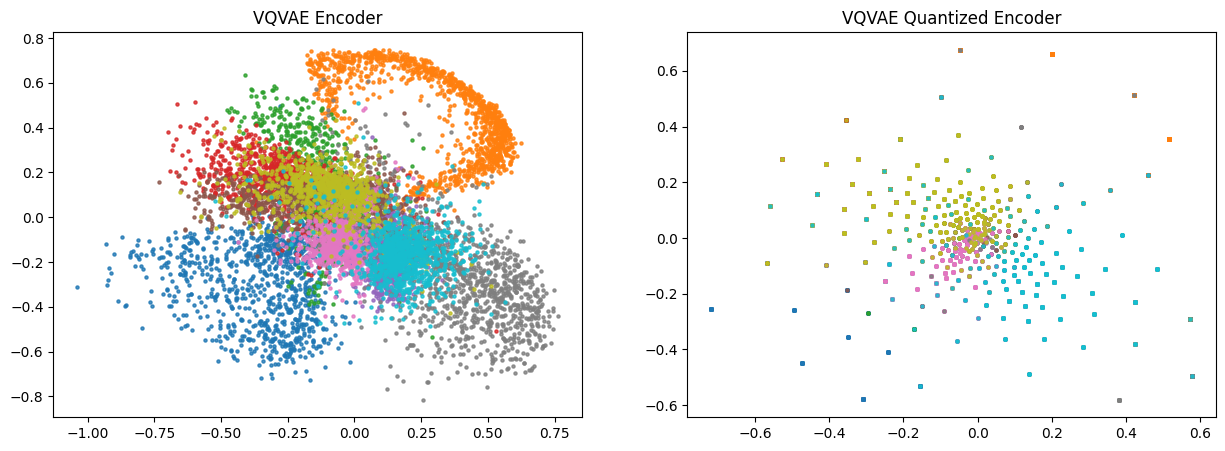

In [8]:
### Grab Encodings ###
import matplotlib.pyplot as plt
import pandas as pd
encoded_latent = linear_vqvae_encoded_data_per_eval[-1]
quantized_encoded_latent = linear_vqvae_quantized_encoded_data_per_eval[-1]

fig, ax = plt.subplots(1,2, figsize=(15,5))

### Plot Continuous Encoded ###
encoded_latent = pd.DataFrame(encoded_latent, columns = ["x","y","class"])
encoded_latent = pd.DataFrame(encoded_latent, columns=["x", "y", "class"])

encoded_latent = encoded_latent.sort_values(by="class")
encoded_latent["class"] = encoded_latent["class"].astype(int).astype(str)
for grouper, group in encoded_latent.groupby("class"):
    ax[0].scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)
ax[0].set_title("VQVAE Encoder")

### Plot Quantized ###
quantized_encoded_latent = pd.DataFrame(quantized_encoded_latent, columns=["x", "y", "class"])
quantized_encoded_latent = quantized_encoded_latent.sort_values(by="class")
quantized_encoded_latent["class"] = quantized_encoded_latent["class"].astype(int).astype(str)
for grouper, group in quantized_encoded_latent.groupby("class"):
    ax[1].scatter(x=group["x"], y=group["y"], label=grouper, alpha=0.8, s=5)
ax[1].set_title("VQVAE Quantized Encoder")
plt.show()

(1, 1, 28, 28)


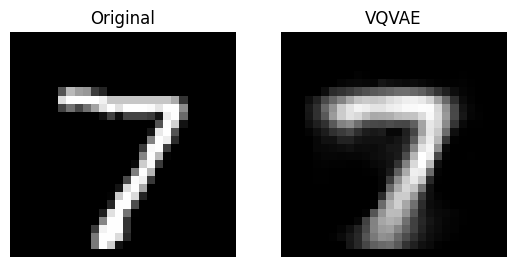

In [9]:
generated_index = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
image, label = test_set[generated_index]
image = image.unsqueeze(0).to(device)


_,vqvae_reconstructed,_, *_ = linear_vqvae(image)

image = image.to("cpu")

vqvae_reconstructed = vqvae_reconstructed.to("cpu").detach().numpy()
print(vqvae_reconstructed.shape)
fig, ax = plt.subplots(1,2)

ax[0].imshow(image.squeeze(), cmap="gray")
ax[0].set_title("Original")
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].axis("off")


ax[1].imshow(vqvae_reconstructed.squeeze(), cmap="gray")
ax[1].set_title("VQVAE")
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].axis("off")


plt.show()

torch.float32
torch.Size([25, 25, 1, 28, 28])


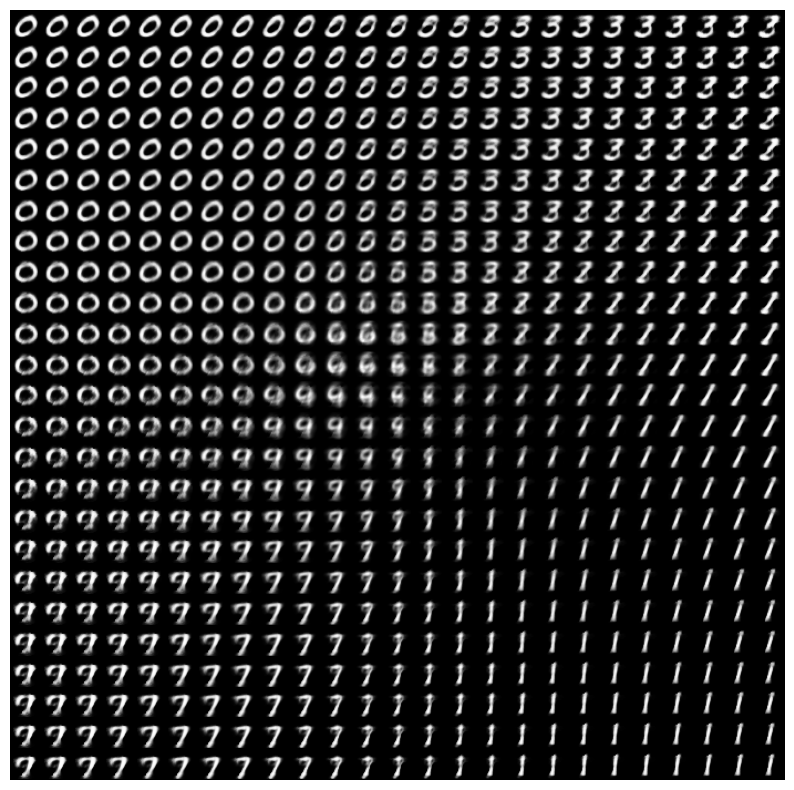

In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def interpolate_space(model,x_range=(-1,1),y_range=(-1,1),num_steps =25):

  x = np.linspace(x_range[0],x_range[1],num_steps)
  y = np.linspace(y_range[0],y_range[1],num_steps)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  points =[]

  for x_p in x:
    for y_p in y:
      points.append([x_p,y_p])
  points_tensor = torch.tensor(points).to(device).to(torch.float32)
  print(points_tensor.dtype)

  model.eval()
  with torch.no_grad():
    reconstructed = model.forward_dec(points_tensor).to('cpu').reshape(-1,1,28,28)
  reconstructed = reconstructed.reshape(num_steps,num_steps,1,28,28)
  print(reconstructed.shape)

  fig,ax = plt.subplots(num_steps,num_steps, figsize = (10,10))

  for x in range(num_steps):
    for y in range(num_steps):
      image = reconstructed[x,y].permute(1,2,0).numpy()
      ax[x,y].imshow(image,cmap = "gray")
      ax[x,y].axis("off")

  fig.subplots_adjust(hspace=0.0,wspace=0.0)
  plt.show()

interpolate_space(linearvqvae)

In our generations, we saw a lot of repeated images. This happens because we’re using fixed quantized latents. The encoder gives us continuous latents, but they get snapped to the nearest code from a fixed set of discrete latents (the codebook).

 So even if two input images are a bit different, they can end up with the same quantized code, and the decoder then produces the same or very similar output — causing repetition.

But there’s an upside to this: the model doesn’t try to learn subtle differences or interpolations between similar images like a VAE would. In VAEs, the model can learn smooth transitions between images (like halfway between a 3 and a 4), which sometimes leads to blurry outputs. But in VQ-VAE, each input is forced to commit to one fixed code — there's no room for "in-between" codes. So instead of blending features, the model learns distinct and sharper representations, even if that means some repetition.

In [7]:
## convolutional vector quantized varaitional autoencoder
import torch.nn as nn

class ConvvectorquantizedVAE(nn.Module):

  def __init__(self,channels=1,latent_dim=4,codebook_size = 512):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(channels,8,kernel_size=3,stride=2,padding=1), # 64 x 28 x 28 x 1 -> 64 x 14 x 14 x 8
        nn.ReLU(),

        nn.Conv2d(in_channels=8, out_channels=32,kernel_size=3,stride=2,padding=1), # 64 x 14 x 14 x 8 -> 64 x 7 x 7 x 32
        nn.ReLU(),

        nn.Conv2d(in_channels=32, out_channels=64,kernel_size=3,stride=2,padding=1), # 64 x 7 x 7 x 32 -> 64 x 4 x 4 x 64
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels=64, out_channels=32,kernel_size=3,stride=2,padding=1), #64 x 4 x 4 x 64 -> 64 x 7 x 7 x 32
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=32, out_channels=8,kernel_size=3,stride=2,padding=1,output_padding=1),# 64 x 7 x 7 x 32 -> 64 x 14 x 14 x 8
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=8, out_channels=1,kernel_size=3,stride=2,padding=1,output_padding=1),# 64 x 14 x 14 x 8 -> 64 x 28 x 28 x 1
        nn.Sigmoid()
    )

    self.codebook_size = codebook_size
    self.latent_dim = latent_dim

    self.vq = VectorQuantizer(codebook_size,latent_dim)

  def forward_enc(self,x):
    return self.encoder(x)

  def forward_vq(self,z):
    # shape -> b,c,h,w --> b, 64 , 28,28
    codes = self.vq(z)

    # codebook and commitment loss #
    codebook_loss = torch.mean((codes - z.detach())**2)
    commitment_loss = torch.mean((codes.detach() - z)**2)

    codes = z + (codes-z).detach()
    return z,codes,codebook_loss,commitment_loss

  def forward_dec(self,x):
    return self.decoder(x)

  def forward(self,x):
    batch_size,channels,height,width = x.shape

    z = self.forward_enc(x)

    z, codes, codebook_loss, commitment_loss = self.forward_vq(z)
    x_hat = self.forward_dec(codes)

    return z,x_hat,codes,codebook_loss,commitment_loss


convvqvae = ConvvectorquantizedVAE()
x = torch.randn((4,1,28,28))
z,x_hat,codes,codebook_loss, commitment_loss= convvqvae(x)
print(z.shape,x_hat.shape,codebook_loss,commitment_loss)

torch.Size([4, 64, 4, 4]) torch.Size([4, 1, 28, 28]) tensor(0.0090, grad_fn=<MeanBackward0>) tensor(0.0090, grad_fn=<MeanBackward0>)


In [35]:
(conv_vqvae, train_losses,
 evaluation_losses, conv_vqvae_encoded_data_per_eval,
 conv_vqvae_quantized_encoded_data_per_eval) = train(convvqvae,
                                                       train_loader,
                                                       test_loader,
                                                       batch_size=64,
                                                       training_iterations=2500,
                                                       evaluation_iterations=250,
                                                       model_type="VQVAE")

100%|█████████▉| 2498/2500 [00:58<00:00, 57.89it/s]

Completed Training!


100%|██████████| 2500/2500 [00:58<00:00, 42.50it/s]

Final Training Loss 0.0038298371210694314
Final Evaluation Loss 0.0037020119968094404


(1, 1, 28, 28)


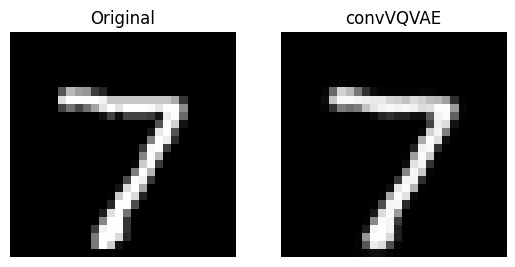

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

generated_index = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
image, label = test_set[generated_index]
image = image.unsqueeze(0).to(device)


_,convvqvae_reconstructed,_, *_ = conv_vqvae(image)

image = image.to("cpu")

convvqvae_reconstructed = convvqvae_reconstructed.to("cpu").detach().numpy()
print(convvqvae_reconstructed.shape)
fig, ax = plt.subplots(1,2)

ax[0].imshow(image.squeeze(), cmap="gray")
ax[0].set_title("Original")
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].axis("off")


ax[1].imshow(convvqvae_reconstructed.squeeze(), cmap="gray")
ax[1].set_title("convVQVAE")
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].axis("off")


plt.show()